# Set up farm run

In [1]:
# Load the amrwind-frontend module
# Add any possible locations of amr-wind-frontend here
amrwindfedirs = ['/ascldap/users/lcheung/wind_uq/amrwind-frontend/',
                 '/ccs/proj/cfd162/lcheung/amrwind-frontend/']
import sys, os, shutil
for x in amrwindfedirs: sys.path.insert(1, x)

# Load the libraries
import amrwind_frontend  as amrwind
import matplotlib.pyplot as plt
import numpy             as np
import math
import pandas as pd
import postproamrwindsample as ppsample
import time
import utm

# Also ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Make all plots inline 
%matplotlib inline

In [2]:
verbose=False

In [3]:
if verbose:
    for x in amrwindfedirs:
        if os.path.exists(x+"/turbines/summitlayoutturbs.yaml"):
            with open(x+"/turbines/summitlayoutturbs.yaml") as f: print(f.read())

In [4]:
def updateturbdf(df, csvfile, col, numhead=1, splitdelim=None):
    csvdat      = [line.strip().split(splitdelim) for line in open(csvfile, 'r')][numhead:]
    for row in csvdat:
        turbname = row[0]
        val      = row[1]
        df.loc[df['# name'] == turbname, col]  = val
    return df

def updateturbs(df, changeKPturb='', numhead=1, splitdelim=None):
    KPcsvfile = 'KP_turbine_yaw.txt'
    df        = updateturbdf(df, KPcsvfile, ' yaw')
    # Change the KP turb type if necessary
    if len(changeKPturb)>0:
        csvdat    = [line.strip().split(splitdelim) for line in open(KPcsvfile, 'r')][numhead:]
        for row in csvdat:
            turbname = row[0]
            df.loc[df['# name'] == turbname, ' type']  = changeKPturb
    return df

def removeturbines(runcase):
    physics = runcase.getAMRWindInput('incflo.physics')
    if 'Actuator' in physics:
        physics.remove('Actuator')
        runcase.setAMRWindInput('physics', physics)
        print('SET incflo.physics: '+repr(runcase.getAMRWindInput('incflo.physics')))
    runcase.setAMRWindInput('ActuatorForcing', False)    
    runcase.listboxpopupwindict['listboxactuator'].deleteall()
    return

In [5]:
# Start the AMR-Wind case
rundir = '/ccs/home/lcheung/scratch.cfd162/AWAKEN/UnstableABL1_farmrun1'
case = amrwind.MyApp.init_nogui()

In [6]:
precursordir  = '/ccs/home/lcheung/scratch.cfd162/AWAKEN/UnstableABL1_precursor2'
#'../precursor/UnstableABL1'
precursorsetup= precursordir+'/UnstableABL_precursor2.inp'
#precursorsetup= './UnstableABL_precursor2.inp'

cwd              = os.getcwd()
farmrundir       = '/ccs/home/lcheung/cfd162/lcheung/AWAKEN_summit_setup/UnstableABL_farmrun1/template'
#'/gpfs/alpine/cfd162/scratch/lcheung/AWAKEN/test/testOFfarmrun'
outputfile       = 'UnstableABL_farmrun1.inp'
noturboutputfile = 'UnstableABL_farmrun1_noturbs.inp'

# Make a copy of the precursor input for posterity
try:
    shutil.copy2(precursorsetup, './')
except:
    pass

# Load the starting point
case.loadAMRWindInput(precursorsetup)

CANNOT update: ABLMeanBoussinesq use forcechange=True in setval()


OrderedDict([('amr.blocking_factor', '32'), ('amr.max_grid_size', '64')])

In [7]:
tstart = 16125
tstop  = 16125+900
textra = 500

In [8]:
# Set the time constants
case.setAMRWindInput('time.stop_time', tstop+textra)
case.setAMRWindInput('time.fixed_dt', 0.1)
case.setAMRWindInput('time.max_step',  -1)

In [9]:
# Set the restart point
chkdir = precursordir+'/chk64500/'
case.setAMRWindInput('restart_file', os.path.realpath(chkdir))

In [10]:
# Set the boundary input file parameters
ablstatfile = precursordir+'/post_processing/abl_statistics59500.nc'
tavg        =  [tstart, tstop]
forcingdict = {'ablstatfile':ablstatfile, 'tavg':tavg}
inflowplanes= ['ylo'] #['ylo', 'xhi']
bndryfiles  = precursordir+'/bndry_fdata'

In [11]:
case.boundaryplane_restart(bndryfiles=bndryfiles, 
                           forcingdict=forcingdict, 
                           inflowplanes=inflowplanes, 
                           verbose=True)

SET ABL_bndry_io_mode = '1'
SET ABL_bndry_file = '/ccs/home/lcheung/scratch.cfd162/AWAKEN/UnstableABL1_precursor2/bndry_fdata'
SET ABL_bndry_planes = ['ylo']
SET is_periodicy = False
SET ylo_type = 'mass_inflow'
SET ylo_density = 1.17
SET ylo_temperature = 0.0
SET ylo_tke = 0.0
SET yhi_type = 'pressure_outflow'
SET yhi_density = None
SET yhi_temperature = None
SET yhi_tke = None
SET BodyForce = True
SET BodyForce_magnitude = [-0.0008322974243443176, 0.00012478819121495535, 0.0]
SET ABLForcing = False
SET ABLMeanBoussinesq = True
SET wall_shear_stress_type = 'local'


## Add turbines

In [12]:
#gitrepo            = '/autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/precursor/UnstableABL1/'
summitcsv          = 'UnstableABL_farmrun_turbines.csv'

# Use this to load the csv directly
#case.loadTurbineCSVFile(summitcsv)

In [13]:
# Load the data from the database of all turbines
allturbsdf = pd.read_csv(summitcsv, low_memory=False)
allturbsdf = updateturbs(allturbsdf)
turbinescsvstring = allturbsdf.to_csv(index=False)
case.setAMRWindInput('turbines_csvtextbox',  turbinescsvstring)

In [14]:
case.setAMRWindInput('turbines_createnewdomain', False)
case.setAMRWindInput('turbines_deleteprev', True)

case.turbines_createAllTurbines()

# # Print out existing list of turbines, just to confirm that the turbines got made
#print(case.listboxpopupwindict['listboxactuator'].getitemlist())

## Add refinement regions

In [15]:
refinementcsv="""
# CSV file should have columns with
# level, upstream, downstream, lateral, below, above, options
level, upstream, downstream, lateral, below, above, options
#0,     30000,    30000,      40000,  100,  1000,      center:farm units:meter
#1,  10000,    7500,    21000,  100,  250, center:specified units:meter centerx:653000 centery:4050000 centerz:100 name:TR
#1,   7500,    6500,    12500,  100,  250, center:specified units:meter centerx:640000 centery:4030000 centerz:100 name:KP
#1,  11000,    9000,    12500,  100,  250, center:specified units:meter centerx:630000 centery:4018000 centerz:100 name:AF
#1,   4000,    3000,     9000,  100,  250, center:specified units:meter centerx:618000 centery:4035000 centerz:100 name:BR
#1,  10000,    5000,    14000,  100,  250, center:specified units:meter centerx:618000 centery:4050000 centerz:100 name:CV
2,     0.6,    0.6,     0.6,    0.525, 0.525, orientation:nacdir
"""
case.setAMRWindInput('refine_csvtextbox', refinementcsv)
case.setAMRWindInput('refine_deleteprev', False)

In [16]:
case.refine_createAllZones()

In [17]:
# Estimate mesh size
case.estimateMeshSize(verbose=False)

ESTIMATED MESH SIZE
   Level       Ncells                      Cell Size
       0   3355443200             20.0 x 20.0 x 20.0
       1   5280000000             10.0 x 10.0 x 10.0
       2   5966800000                5.0 x 5.0 x 5.0
       3     65492614                2.5 x 2.5 x 2.5
  TOTAL:  14667735814


In [18]:
#print(case.listboxpopupwindict['listboxtagging'].getitemlist())

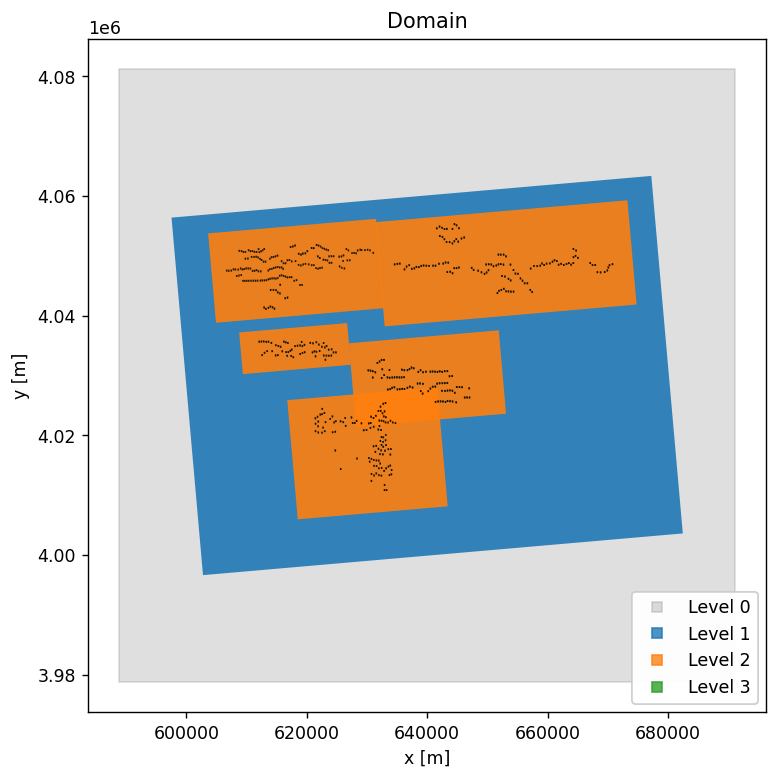

In [19]:
# Plot the domain
fig, ax = plt.subplots(figsize=(7,7), facecolor='w', dpi=125)

# Set any additional items to plot
case.popup_storteddata['plotdomain']['plot_windnortharrows'] = False
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = [] #['p_hub']
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XY'#'YZ' 
case.popup_storteddata['plotdomain']['plot_refineboxes']     = case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.plotDomain(ax=ax)
#ax.axis('auto')
#ax.axis([620000, 621000, 4020000, 4021000])
#ax.set_xlim([620000, 621000])
#ax.set_ylim([4020000, 4021000])

ax.set_aspect('auto')
#ax.set_xlim([640000,  650000])
#ax.set_ylim([4025000, 4035000])

## Set up averaging

In [20]:
# Delete all old sampling planes from precursor
case.listboxpopupwindict['listboxsampling'].deleteall()
case.listboxpopupwindict['listboxpostprosetup'].deleteall()
print(case.listboxpopupwindict['listboxsampling'].getitemlist())
print(case.listboxpopupwindict['listboxpostprosetup'].getitemlist())

[]
[]


In [21]:
# Set up averaging
avgsetup = case.get_default_postprosetupdict() 
avgsetup['postprocessing_setup_name']             = 'averaging'
avgsetup['postprocessing_setup_type']             = 'TimeAveraging'
avgsetup['postprocessing_setup_averaging_window']     = 60.0
avgsetup['postprocessing_setup_averaging_start_time'] = tstart
avgsetup['postprocessing_setup_averaging_stop_time']  = 1.0E6
#case.add_populatefromdict('listboxpostprosetup', avgsetup, verbose=True)
case.add_postprosetup(avgsetup, verbose=True)

postprocessing_setup_name: 'averaging'
postprocessing_setup_type: 'TimeAveraging'
postprocessing_setup_output_frequency: 100
postprocessing_setup_fields: 'velocity'
postprocessing_setup_averaging_window: 60.0
postprocessing_setup_averaging_start_time: 16125
postprocessing_setup_averaging_stop_time: 1000000.0


In [22]:
avgobject                             = case.get_default_averagingdict()
avgobject['averaging_name']           = 'mean_average'
avgobject['averaging_averaging_type'] = 'ReAveraging'
avgobject['averaging_fields']         = 'velocity'
case.add_averaging(avgobject, verbose=True)

averaging_name: 'mean_average'
averaging_outputto: 'averaging'
averaging_averaging_type: 'ReAveraging'
averaging_fields: 'velocity'


## Add metmast sampling

In [23]:
# Set up averaging
metmastpprosetup = case.get_default_postprosetupdict()
metmastpprosetup['postprocessing_setup_name'] = 'metmast_'
metmastpprosetup['postprocessing_setup_type'] = 'Sampling'
metmastpprosetup['postprocessing_setup_output_frequency'] =  1
metmastpprosetup['postprocessing_setup_fields']           =  'velocity'
case.add_postprosetup(metmastpprosetup, verbose=True)

postprocessing_setup_name: 'metmast_'
postprocessing_setup_type: 'Sampling'
postprocessing_setup_output_frequency: 1
postprocessing_setup_fields: 'velocity'
postprocessing_setup_averaging_window: None
postprocessing_setup_averaging_start_time: None
postprocessing_setup_averaging_stop_time: None


In [24]:
site_xy   = [{'name':'H', 'long':-97.405716, 'lat':36.437261},
             {'name':'E', 'long':-97.406248, 'lat':36.379412},
             {'name':'G', 'long':-97.405855, 'lat':36.410075},
            ]
for site in site_xy:
    site['utm'] = utm.from_latlon(site['lat'], site['long'])
    
#Add Engie probe
site_xy.append({'name':'Engie1','utm':(643311, 4025472, 14, 'S' )})

In [25]:
# Add metmast 
for site in site_xy:
    sampledict = case.get_default_samplingdict()
    sampledict['sampling_name']     = 'metmast_'+site['name']
    sampledict['sampling_outputto'] = 'metmast_'
    sampledict['sampling_type']     = 'LineSampler'
    sampledict['sampling_l_num_points'] = 50
    sampledict['sampling_l_start']      = [site['utm'][0], site['utm'][1], 10]
    sampledict['sampling_l_end']        = [site['utm'][0], site['utm'][1], 500]
    case.add_sampling(sampledict, verbose=False)

(4020000.0, 4045000.0)

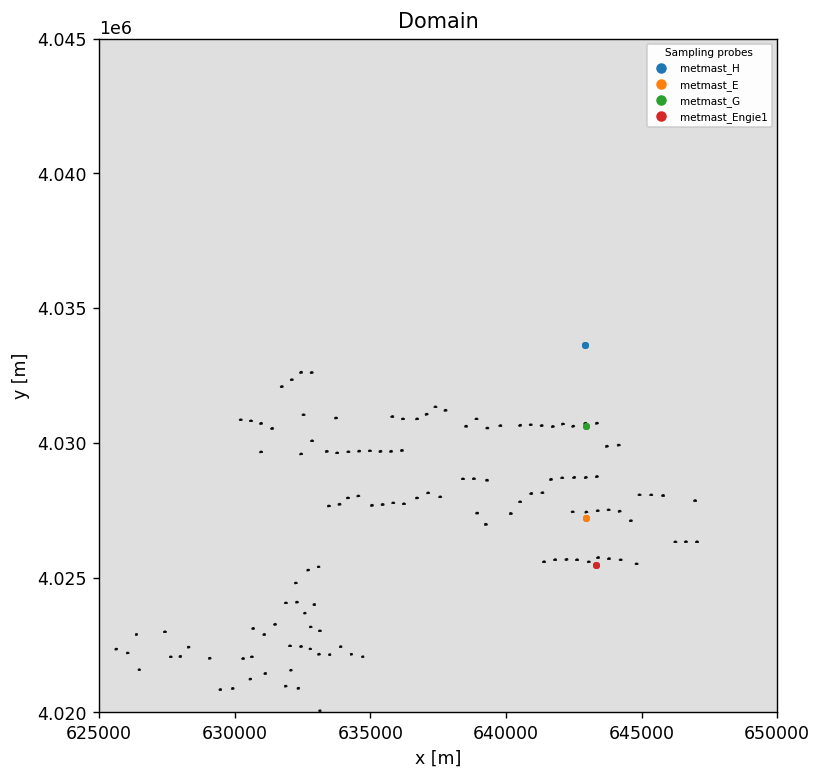

In [26]:
# Plot the domain
fig, ax = plt.subplots(figsize=(7,7), facecolor='w', dpi=125)

# Set any additional items to plot
case.popup_storteddata['plotdomain']['plot_sampleprobes_style']  = "{'markersize':5, 'marker':'.', 'linestyle':'None', }"
case.popup_storteddata['plotdomain']['plot_sampleprobes_legend'] = "{'title':'Sampling probes', 'fontsize':6, 'loc':'upper right', 'markerscale':2}"
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = case.listboxpopupwindict['listboxsampling'].getitemlist() 
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XY'
case.popup_storteddata['plotdomain']['plot_refineboxes']     = [] 
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_windnortharrows'] = False
start = time.time()
case.plotDomain(ax=ax, verbose=False)

ax.set_aspect('auto')
ax.set_xlim([625000,  650000])
ax.set_ylim([4020000, 4045000])

## Add sampling planes

In [27]:
farm_domainsize = [102400, 102400, 2560]
farm_center     = [640000, 4030000]   # In utm

In [28]:
outputoptions="outputvars:velocity;tke;temperature;velocity_mean outputfreq:10"

samplingcsv = """
# CSV file should have columns withturbinescsv=
# name, type, upstream, downstream, lateral, below, above, n1, n2, options
name, type, upstream, downstream, lateral, below, above, n1, n2, options
hh90,  hubheight, {up}, {down}, {lateral}, 0,  none,  11, 11, usedx:{dx} units:meter center:specified centerx:{centerx} centery:{centery} centerz:90 orientation:y \
  outputto:farm_z90_ {outputoptions} 
hh153,  hubheight, {up}, {down}, {lateral}, 0,  none,  11, 11, usedx:{dx} units:meter center:specified centerx:{centerx} centery:{centery} centerz:153 orientation:y \
  outputto:farm_z153_ {outputoptions} 
""".format(centerx=farm_center[0], centery=farm_center[1], up=0.5*farm_domainsize[0], down=0.5*farm_domainsize[0], lateral=0.5*farm_domainsize[1], 
           dx=200, outputoptions=outputoptions)

samplingcsv += """
# King plains inflow/outflow
KP500, hubheight, 8500,  8500, 12500,  0, none, 0, 0,              usedx:20 units:meter center:specified centerx:640000 centery:4030000 centerz:500 outputto:KP_z500hh_ {outputoptions}        
KP153, hubheight, 8500,  8500, 12500,  0, none, 0, 0,              usedx:20 units:meter center:specified centerx:640000 centery:4030000 centerz:153 outputto:KP_z153ut_   {outputoptions}
KP090, hubheight, 8500,  8500, 12500,  0, none, 0, 0,              usedx:20 units:meter center:specified centerx:640000 centery:4030000 centerz:90 outputto:KP_z090hh_   {outputoptions}
KP026, hubheight, 8500,  8500, 12500,  0, none, 0, 0,              usedx:20 units:meter center:specified centerx:640000 centery:4030000 centerz:26 outputto:KP_z026lt_   {outputoptions}
KP_ioflow1,  rotorplane, 8500,   8500, 12500,  100, 400, 0, 0,     usedx:20 units:meter center:specified centerx:640000 centery:4030000 centerz:100 outputto:KP_inflow1_ noffsets:4 {outputoptions}
KP_sideplane1, streamwise, 8500, 8500, 12500,  100, 400, 0, 0,     usedx:20 units:meter center:specified centerx:640000 centery:4030000 centerz:100 outputto:KP_sideplane1_ noffsets:2 {outputoptions}
KP_sideplane2, streamwise, 8500, 8500, -12500,  100, 400, 0, 0,    usedx:20 units:meter center:specified centerx:640000 centery:4030000 centerz:100 outputto:KP_sideplane2_ noffsets:2 {outputoptions}

# AF planes
AF130, hubheight, 11000, 9000, 12500,  0, none, 0, 0,              usedx:20 units:meter center:specified centerx:630000 centery:4018000 centerz:130 outputto:AF_z130ut_ {outputoptions}
AF080, hubheight, 11000, 9000, 12500,  0, none, 0, 0,              usedx:20 units:meter center:specified centerx:630000 centery:4018000 centerz:80 outputto:AF_z080hh_ {outputoptions}
AF030, hubheight, 11000, 9000, 12500,  0, none, 0, 0,              usedx:20 units:meter center:specified centerx:630000 centery:4018000 centerz:30 outputto:AF_z030lt_ {outputoptions}
AF_ioflow,     rotorplane, 11000, 9000, 12500,  100, 400, 0, 0,    usedx:20 units:meter center:specified centerx:630000 centery:4018000 centerz:100 outputto:AF_ioflow_ noffsets:1 {outputoptions}
AF_sideplane1, streamwise, 11000, 9000, 12500,  100, 400, 0, 0,    usedx:20 units:meter center:specified centerx:630000 centery:4018000 centerz:100 outputto:AF_sideplane1_ noffsets:1 {outputoptions}
AF_sideplane2, streamwise, 11000, 9000, -12500,  100, 400, 0, 0,   usedx:20 units:meter center:specified centerx:630000 centery:4018000 centerz:100 outputto:AF_sideplane2_ noffsets:1 {outputoptions}

# TR planes
TR148, hubheight, 10000, 7500, 21000, 0,  none,  11, 11,           usedx:20 units:meter center:specified centerx:653000 centery:4050000 centerz:148 outputto:TR_z148ut_ {outputoptions}
TR090, hubheight, 10000, 7500, 21000, 0,  none,  11, 11,           usedx:20 units:meter center:specified centerx:653000 centery:4050000 centerz:90 outputto:TR_z090hh_ {outputoptions}
TR032, hubheight, 10000, 7500, 21000, 0,  none,  11, 11,           usedx:20 units:meter center:specified centerx:653000 centery:4050000 centerz:32 outputto:TR_z032lt_ {outputoptions}
TR_ioflow,     rotorplane, 10000, 7500, 21000, 100, 400, 0, 0,     usedx:20 units:meter center:specified centerx:653000 centery:4050000 centerz:100 outputto:TR_ioflow_ noffsets:1 {outputoptions}
TR_sideplane1, streamwise, 10000, 7500, 21000, 100, 400, 0, 0,     usedx:20 units:meter center:specified centerx:653000 centery:4050000 centerz:100 outputto:TR_sideplane1_ noffsets:1 {outputoptions}
TR_sideplane2, streamwise, 10000, 7500, -21000, 100, 400, 0, 0,    usedx:20 units:meter center:specified centerx:653000 centery:4050000 centerz:100 outputto:TR_sideplane2_ noffsets:1 {outputoptions}

# BR planes
BR132, hubheight, 4000,  3000, 9000,   0, none, 0, 0,              usedx:20 units:meter center:specified centerx:618000 centery:4035000 centerz:132 outputto:BR_z132ut_ {outputoptions}
BR080, hubheight, 4000,  3000, 9000,   0, none, 0, 0,              usedx:20 units:meter center:specified centerx:618000 centery:4035000 centerz:80 outputto:BR_z080hh_ {outputoptions}
BR029, hubheight, 4000,  3000, 9000,   0, none, 0, 0,              usedx:20 units:meter center:specified centerx:618000 centery:4035000 centerz:29 outputto:BR_z029lt_ {outputoptions}
BR_ioflow,     rotorplane, 4000,  3000, 9000,  100, 400, 0, 0,     usedx:20 units:meter center:specified centerx:618000 centery:4035000 centerz:100 outputto:BR_ioflow_ noffsets:1 {outputoptions}
BR_sideplane1, streamwise, 4000,  3000, 9000,  100, 400, 0, 0,     usedx:20 units:meter center:specified centerx:618000 centery:4035000 centerz:100 outputto:BR_sideplane1_ noffsets:1 {outputoptions}
BR_sideplane2, streamwise, 4000,  3000, -9000,  100, 400, 0, 0,    usedx:20 units:meter center:specified centerx:618000 centery:4035000 centerz:100 outputto:BR_sideplane2_ noffsets:1 {outputoptions}

# CV planes
CV121, hubheight, 10000, 5000, 14000,  0, none, 0, 0,              usedx:20 units:meter center:specified centerx:618000 centery:4050000 centerz:121 outputto:CV_z121ut_ {outputoptions}
CV080, hubheight, 10000, 5000, 14000,  0, none, 0, 0,              usedx:20 units:meter center:specified centerx:618000 centery:4050000 centerz:80 outputto:CV_z080hh_ {outputoptions}
CV039, hubheight, 10000, 5000, 14000,  0, none, 0, 0,              usedx:20 units:meter center:specified centerx:618000 centery:4050000 centerz:39 outputto:CV_z039lt_ {outputoptions}
CV_ioflow,     rotorplane, 10000, 5000, 14000, 100, 400, 0, 0,     usedx:20 units:meter center:specified centerx:618000 centery:4050000 centerz:90 outputto:CV_ioflow_ noffsets:1 {outputoptions}
CV_sideplane1, streamwise, 10000, 5000, 14000, 100, 400, 0, 0,     usedx:20 units:meter center:specified centerx:618000 centery:4050000 centerz:90 outputto:CV_sideplane1_ noffsets:1 {outputoptions}
CV_sideplane2, streamwise, 10000, 5000, -14000, 100, 400, 0, 0,    usedx:20 units:meter center:specified centerx:618000 centery:4050000 centerz:90 outputto:CV_sideplane2_ noffsets:1 {outputoptions}
""".format(outputoptions=outputoptions)
case.setAMRWindInput('sampling_csvtextbox', samplingcsv)
case.setAMRWindInput('sampling_deleteprev', False)

In [29]:
case.sampling_createAllProbes(verbose=False)

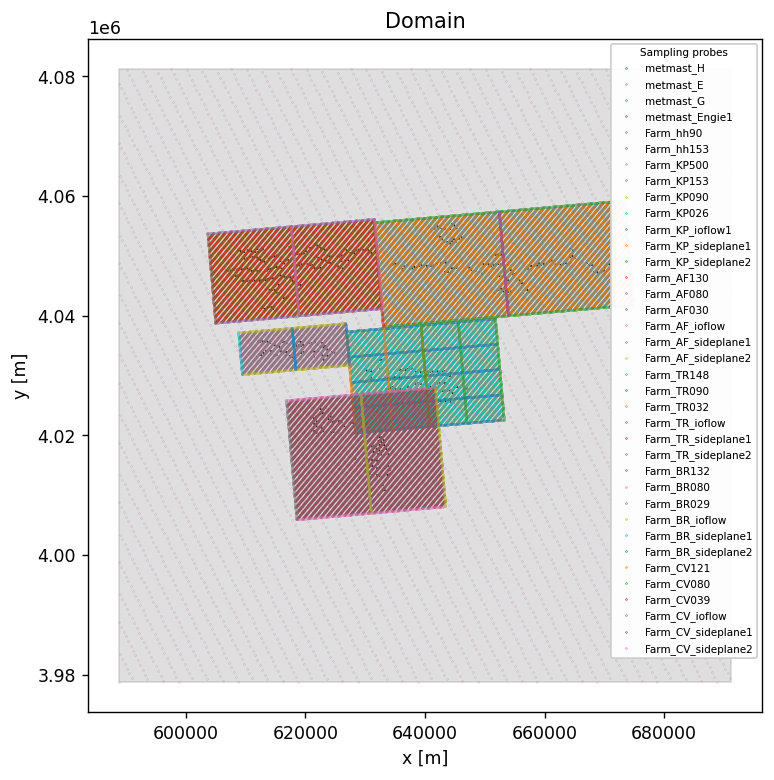

In [30]:
# Plot the domain
fig, ax = plt.subplots(figsize=(7,7), facecolor='w', dpi=125)

# Set any additional items to plot
case.popup_storteddata['plotdomain']['plot_sampleprobes_style']  = "{'markersize':0.1, 'marker':'.', 'linestyle':'None', }"
case.popup_storteddata['plotdomain']['plot_sampleprobes_legend'] = "{'title':'Sampling probes', 'fontsize':6, 'loc':'upper right', 'markerscale':6}"
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = case.listboxpopupwindict['listboxsampling'].getitemlist() 
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XY'
case.popup_storteddata['plotdomain']['plot_refineboxes']     = [] 
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_windnortharrows'] = False
start = time.time()
case.plotDomain(ax=ax, verbose=False, plotskip=50)

### Add some sampling just for King Plains turbines

In [31]:
# Load the data from the database of all turbines
allturbsdf = pd.read_csv(summitcsv, low_memory=False)
allturbsdf = updateturbs(allturbsdf)

In [32]:
# Get just the King Plains turbines
subset = [] 
for x in allturbsdf.iterrows():
    if x[1]['# name'].endswith('-KP'):
        subset.append(x[1])
subsetdf = pd.DataFrame(subset[:])

KP_turbinescsv = subsetdf.to_csv(index=False)
#print(subsetdf.to_csv(index=False))

```
# Load the yaw file
yawfile         = 'KP_turbine_yaw.txt'
subsetdf = updateturbdf(subsetdf, yawfile, ' yaw')
#subsetdf.columns
#subsetdf.head()
KP_turbinescsv = subsetdf.to_csv(index=False)
```

In [33]:
#print(subsetdf.columns)
#subsetdf.at[0, ' yaw'] = 171.955875
#subsetdf.loc[subsetdf['# name'] == '2019-WTW-4713-KP', ' yaw'] = 171.955875
#subsetdf.loc[subsetdf['# name'] == '2019-WTW-4655-KP', ' yaw'] = 169.628694
#subsetdf.head()

In [34]:
case.setAMRWindInput('turbines_csvtextbox',  KP_turbinescsv)
case.setAMRWindInput('turbines_deleteprev', True)
#case.listboxpopupwindict['listboxactuator'].deleteall()
case.turbines_createAllTurbines()

In [35]:
outputoptions="outputvars:velocity;tke;temperature;velocity_mean outputfreq:10"

KPsamplingcsv = """
# CSV file should have columns withturbinescsv=
# name, type, upstream, downstream, lateral, below, above, n1, n2, options
name,      type, upstream, downstream, lateral, below, above, n1, n2, options
KPturbhh,  hubheight, 1020, 1020,       130,     0,     0,     11, 11, usedx:10 units:meter outputto:KPturbhh_ orientation:nacdir outputvars:velocity  {outputoptions}
KPsw,     streamwise, 1020, 1020,       0,       90,    130,   11, 11, usedx:10 units:meter outputto:KPsw_     orientation:nacdir outputvars:velocity   {outputoptions}
KProtor,  rotorplane, 1020, 1020,       130,     ,      130,   11, 11, usedx:10 units:meter outputto:KProtor_  orientation:nacdir outputvars:velocity noffsets:8  {outputoptions}
""".format(outputoptions=outputoptions)

In [36]:
case.setAMRWindInput('sampling_csvtextbox', KPsamplingcsv)
case.setAMRWindInput('sampling_deleteprev', False)

In [37]:
case.sampling_createAllProbes(verbose=False)
# Print out existing list of turbines
#print(case.listboxpopupwindict['listboxsampling'].getitemlist())

In [38]:
KPturbhh = [x for x in case.listboxpopupwindict['listboxsampling'].getitemlist() if x.endswith('_KPturbhh') ]
KPsw     = [x for x in case.listboxpopupwindict['listboxsampling'].getitemlist() if x.endswith('_KPsw') ]
KProtor  = [x for x in case.listboxpopupwindict['listboxsampling'].getitemlist() if x.endswith('_KProtor') ]

Time: 165.61806559562683


(4025000.0, 4035000.0)

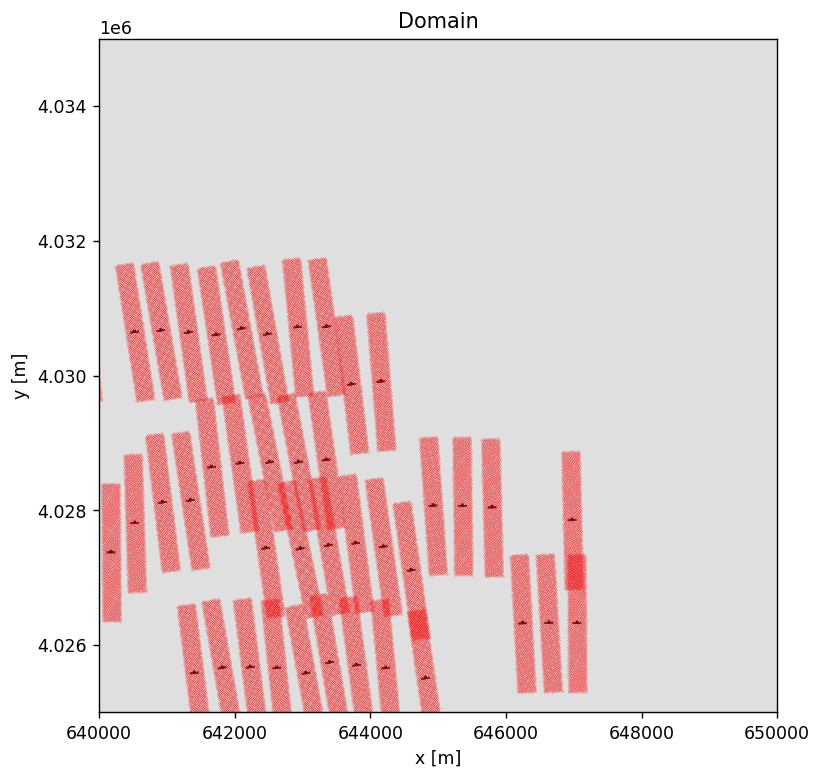

In [39]:
# Plot the domain
fig, ax = plt.subplots(figsize=(7,7), facecolor='w', dpi=125)

# Set any additional items to plot
case.popup_storteddata['plotdomain']['plot_sampleprobes_style']  = "{'markersize':0.25, 'marker':'.', 'linestyle':'None', 'mfc':'r', 'markeredgecolor':'r'}"
case.popup_storteddata['plotdomain']['plot_sampleprobes_legend'] = "{}" #"{'title':'Sampling probes', 'fontsize':6, 'loc':'upper right', 'markerscale':6}"
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = KPturbhh #['p_hub']
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XY'#'YZ' 
case.popup_storteddata['plotdomain']['plot_refineboxes']     = [] #case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_windnortharrows'] = False
start = time.time()
case.plotDomain(ax=ax, verbose=False, plotskip=5)
end = time.time()
print("Time: "+repr(end - start))

"""
case.popup_storteddata['plotdomain']['plot_sampleprobes_style']  = "{'markersize':0.1, 'marker':'.', 'linestyle':'None', 'mfc':'g', 'markeredgecolor':'g'}"
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = KProtor #['p_hub']
start = time.time()
case.plotDomain(ax=ax, verbose=False)
end = time.time()
print("Time: "+repr(end - start))

case.popup_storteddata['plotdomain']['plot_sampleprobes_style']  = "{'markersize':0.1, 'marker':'.', 'linestyle':'None', 'mfc':'b', 'markeredgecolor':'b'}"
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = KPsw #['p_hub']
start = time.time()
case.plotDomain(ax=ax, verbose=False)
end = time.time()
print("Time: "+repr(end - start))
"""
ax.set_aspect('auto')
ax.set_xlim([640000,  650000])
ax.set_ylim([4025000, 4035000])

## Print the input file

### Set up the turbine case

In [40]:
os.chdir(cwd)

# remove all of the existing turbines, and add them back (with OpenFAST/ADM)
removeturbines(case)
allturbsdf = pd.read_csv(summitcsv, low_memory=False)
allturbsdf = updateturbs(allturbsdf, changeKPturb='Summit_GE2.8-127_ADM')
turbinescsvstring = allturbsdf.to_csv(index=False)
case.setAMRWindInput('turbines_csvtextbox',  turbinescsvstring)
case.setAMRWindInput('turbines_createnewdomain', False)
case.setAMRWindInput('turbines_deleteprev', True)

# Go to the run directory
if not os.path.exists(farmrundir):
    os.makedirs(farmrundir)
os.chdir(farmrundir)

# Create all of the turbines
case.turbines_createAllTurbines()

# Write the input file
inputfile=case.writeAMRWindInput(outputfile)
if verbose: print(inputfile)

# Make a copy of the file
shutil.copy2(outputfile, cwd)
os.chdir(cwd)

SET incflo.physics: ['ABL']
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4713-KP_OpenFAST3p3_NREL2p8-127.bugfix
2019-WTW-4713-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4713-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4655-KP_OpenFAST3p3_NREL2p8-127.bugfix


98.04412500000001 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4655-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4655-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4651-KP_OpenFAST3p3_NREL2p8-127.bugfix


100.371306 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4651-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4651-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4726-KP_OpenFAST3p3_NREL2p8-127.bugfix


 98.869059 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4726-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4726-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4671-KP_OpenFAST3p3_NREL2p8-127.bugfix


 90.442061 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4671-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4671-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4715-KP_OpenFAST3p3_NREL2p8-127.bugfix


 96.742388 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4715-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4715-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4691-KP_OpenFAST3p3_NREL2p8-127.bugfix


97.07272599999999 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4691-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4691-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-7913-KP_OpenFAST3p3_NREL2p8-127.bugfix


91.72821099999999 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-7913-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-7913-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4657-KP_OpenFAST3p3_NREL2p8-127.bugfix


 91.451145 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4657-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4657-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4694-KP_OpenFAST3p3_NREL2p8-127.bugfix


95.49095299999999 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4694-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4694-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4718-KP_OpenFAST3p3_NREL2p8-127.bugfix


96.46533199999999 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4718-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4718-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4690-KP_OpenFAST3p3_NREL2p8-127.bugfix


 96.093681 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4690-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4690-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4656-KP_OpenFAST3p3_NREL2p8-127.bugfix


 90.519511 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4656-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4656-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4697-KP_OpenFAST3p3_NREL2p8-127.bugfix


99.93746999999999 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4697-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4697-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4698-KP_OpenFAST3p3_NREL2p8-127.bugfix


100.80955800000001 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4698-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4698-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4701-KP_OpenFAST3p3_NREL2p8-127.bugfix


 98.177078 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4701-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4701-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4723-KP_OpenFAST3p3_NREL2p8-127.bugfix


 94.015795 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4723-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4723-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4673-KP_OpenFAST3p3_NREL2p8-127.bugfix


98.17868999999999 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4673-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4673-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4716-KP_OpenFAST3p3_NREL2p8-127.bugfix


 92.601811 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4716-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4716-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4693-KP_OpenFAST3p3_NREL2p8-127.bugfix


99.87603100000001 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4693-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4693-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4725-KP_OpenFAST3p3_NREL2p8-127.bugfix


98.46925200000001 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4725-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4725-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-7915-KP_OpenFAST3p3_NREL2p8-127.bugfix


93.35955899999999 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-7915-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-7915-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4674-KP_OpenFAST3p3_NREL2p8-127.bugfix


100.245258 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4674-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4674-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4689-KP_OpenFAST3p3_NREL2p8-127.bugfix


90.14610400000001 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4689-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4689-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-7921-KP_OpenFAST3p3_NREL2p8-127.bugfix


 90.211749 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-7921-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-7921-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4710-KP_OpenFAST3p3_NREL2p8-127.bugfix


89.69773599999999 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4710-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4710-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4648-KP_OpenFAST3p3_NREL2p8-127.bugfix


 99.719536 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4648-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4648-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4721-KP_OpenFAST3p3_NREL2p8-127.bugfix


 89.500903 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4721-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4721-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4652-KP_OpenFAST3p3_NREL2p8-127.bugfix


97.51501200000001 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4652-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4652-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4658-KP_OpenFAST3p3_NREL2p8-127.bugfix


99.68423100000001 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4658-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4658-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4692-KP_OpenFAST3p3_NREL2p8-127.bugfix


98.00129799999999 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4692-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4692-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4695-KP_OpenFAST3p3_NREL2p8-127.bugfix


96.90367900000001 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4695-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4695-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-7914-KP_OpenFAST3p3_NREL2p8-127.bugfix


 97.873109 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-7914-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-7914-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4675-KP_OpenFAST3p3_NREL2p8-127.bugfix


  98.04198 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4675-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4675-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4702-KP_OpenFAST3p3_NREL2p8-127.bugfix


 88.963355 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4702-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4702-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4704-KP_OpenFAST3p3_NREL2p8-127.bugfix


90.76490999999999 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4704-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4704-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4712-KP_OpenFAST3p3_NREL2p8-127.bugfix


91.35950199999999 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4712-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4712-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-7916-KP_OpenFAST3p3_NREL2p8-127.bugfix


 97.944737 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-7916-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-7916-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4711-KP_OpenFAST3p3_NREL2p8-127.bugfix


 99.520882 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4711-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4711-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-7912-KP_OpenFAST3p3_NREL2p8-127.bugfix


 97.238586 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-7912-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-7912-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4654-KP_OpenFAST3p3_NREL2p8-127.bugfix


90.45418699999999 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4654-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4654-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4650-KP_OpenFAST3p3_NREL2p8-127.bugfix


 98.399181 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4650-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4650-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4653-KP_OpenFAST3p3_NREL2p8-127.bugfix


 96.267597 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4653-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4653-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4722-KP_OpenFAST3p3_NREL2p8-127.bugfix


97.92021600000001 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4722-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4722-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4717-KP_OpenFAST3p3_NREL2p8-127.bugfix


95.33956599999999 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4717-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4717-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4703-KP_OpenFAST3p3_NREL2p8-127.bugfix


97.12930499999999 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4703-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4703-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4709-KP_OpenFAST3p3_NREL2p8-127.bugfix


  91.45057 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4709-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4709-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4672-KP_OpenFAST3p3_NREL2p8-127.bugfix


101.815482 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4672-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4672-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4696-KP_OpenFAST3p3_NREL2p8-127.bugfix


94.56621799999999 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4696-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4696-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4724-KP_OpenFAST3p3_NREL2p8-127.bugfix


101.174969 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4724-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4724-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-7910-KP_OpenFAST3p3_NREL2p8-127.bugfix


93.11034599999999 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-7910-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-7910-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4683-KP_OpenFAST3p3_NREL2p8-127.bugfix


 95.832065 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4683-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4683-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4737-KP_OpenFAST3p3_NREL2p8-127.bugfix


 91.273356 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4737-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4737-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4732-KP_OpenFAST3p3_NREL2p8-127.bugfix


93.19639900000001 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4732-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4732-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4668-KP_OpenFAST3p3_NREL2p8-127.bugfix


 95.513566 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4668-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4668-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4643-KP_OpenFAST3p3_NREL2p8-127.bugfix


 97.317545 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4643-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4643-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4663-KP_OpenFAST3p3_NREL2p8-127.bugfix


100.502444 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4663-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4663-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-7919-KP_OpenFAST3p3_NREL2p8-127.bugfix


  94.73055 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-7919-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-7919-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4730-KP_OpenFAST3p3_NREL2p8-127.bugfix


93.97035600000001 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4730-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4730-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-7918-KP_OpenFAST3p3_NREL2p8-127.bugfix


98.27467899999999 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-7918-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-7918-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4736-KP_OpenFAST3p3_NREL2p8-127.bugfix


 93.812466 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4736-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4736-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4731-KP_OpenFAST3p3_NREL2p8-127.bugfix


 95.938095 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4731-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4731-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4677-KP_OpenFAST3p3_NREL2p8-127.bugfix


96.32738499999999 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4677-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4677-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4670-KP_OpenFAST3p3_NREL2p8-127.bugfix


94.51696899999999 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4670-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4670-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4642-KP_OpenFAST3p3_NREL2p8-127.bugfix


93.03940499999999 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4642-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4642-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4662-KP_OpenFAST3p3_NREL2p8-127.bugfix


 96.001205 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4662-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4662-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-7920-KP_OpenFAST3p3_NREL2p8-127.bugfix


 95.487549 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-7920-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-7920-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4678-KP_OpenFAST3p3_NREL2p8-127.bugfix


96.10886500000001 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4678-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4678-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-7911-KP_OpenFAST3p3_NREL2p8-127.bugfix


 93.958854 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-7911-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-7911-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4664-KP_OpenFAST3p3_NREL2p8-127.bugfix


93.51755399999999 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4664-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4664-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4679-KP_OpenFAST3p3_NREL2p8-127.bugfix


 92.618934 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4679-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4679-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4669-KP_OpenFAST3p3_NREL2p8-127.bugfix


95.00058200000001 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4669-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4669-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4687-KP_OpenFAST3p3_NREL2p8-127.bugfix


95.42472000000001 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4687-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4687-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4680-KP_OpenFAST3p3_NREL2p8-127.bugfix


  99.01709 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4680-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4680-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4666-KP_OpenFAST3p3_NREL2p8-127.bugfix


 95.396412 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4666-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4666-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4644-KP_OpenFAST3p3_NREL2p8-127.bugfix


 94.620787 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4644-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4644-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4682-KP_OpenFAST3p3_NREL2p8-127.bugfix


98.22187299999999 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4682-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4682-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-7917-KP_OpenFAST3p3_NREL2p8-127.bugfix


93.33918600000001 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-7917-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-7917-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4676-KP_OpenFAST3p3_NREL2p8-127.bugfix


 95.257193 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4676-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4676-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4667-KP_OpenFAST3p3_NREL2p8-127.bugfix


95.42612199999999 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4667-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4667-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4681-KP_OpenFAST3p3_NREL2p8-127.bugfix


 94.176841 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4681-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4681-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4740-KP_OpenFAST3p3_NREL2p8-127.bugfix


 94.808112 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4740-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4740-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4686-KP_OpenFAST3p3_NREL2p8-127.bugfix


93.69485900000001 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4686-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4686-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4741-KP_OpenFAST3p3_NREL2p8-127.bugfix


99.25914499999999 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4741-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4741-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4665-KP_OpenFAST3p3_NREL2p8-127.bugfix


 95.406056 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4665-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4665-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4641-KP_OpenFAST3p3_NREL2p8-127.bugfix


93.84436199999999 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4641-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4641-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4661-KP_OpenFAST3p3_NREL2p8-127.bugfix


 95.751148 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4661-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4661-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4729-KP_OpenFAST3p3_NREL2p8-127.bugfix


 95.435395 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


2019-WTW-4729-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/farmrun/template/2019-WTW-4729-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127_ElastoDyn.dat


98.75767300000001 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


### Set up the no-turbine case

In [41]:
os.chdir(cwd)
removeturbines(case)
inputfile=case.writeAMRWindInput(noturboutputfile)
if verbose: print(inputfile)

SET incflo.physics: ['ABL']
